# Opening the black box of deep learning

N. Tishby and R. Schwartz-Ziv investigated the information flow in deep learning in their paper [Opening the black box of Deep Neural Networks via Information, 2017](https://arxiv.org/abs/1703.00810). They argued, the learning process of a neural network with the stochastic gradient descend undergoes two phases - fitting and compression. During the first phase, a model "overfits" the training data and accumulates the data entropy / variability. During the second phase, a model forgets redundant entropy of the input data, finds the descriptive statistics and compresses data representation.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSWvffYjQblJpgvKlpb8JT3yUpbPrEniFun0gvdco-974ClwvrAnw)

In this tutorial we'll examine these two phases on MNIST and CIFAR10 datasets in PyTorch.


In [0]:
# install required packages
!pip install torchvision==0.2.1 matplotlib==3.0.1 scikit-learn==0.20.0 numpy==1.15.4 pillow==4.1.1

    100% |████████████████████████████████| 61kB 5.0MB/s 
    100% |████████████████████████████████| 12.9MB 1.1MB/s 
    100% |████████████████████████████████| 5.3MB 8.9MB/s 
    100% |████████████████████████████████| 13.9MB 3.5MB/s 
    100% |████████████████████████████████| 5.7MB 7.3MB/s 
    100% |████████████████████████████████| 519.5MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a1ae000 @  0x7fe0d0a412a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 952kB 4.7MB/s 
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Foun

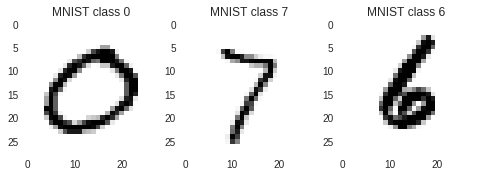

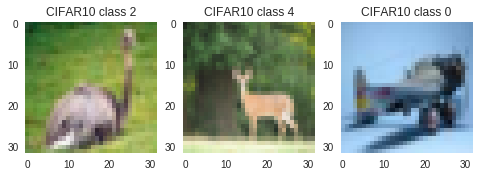

In [0]:
from collections import namedtuple, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import sklearn.cluster
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import transforms, datasets

torch.random.manual_seed(26)
np.random.seed(26)

DATA_DIR = 'data'
BATCH_SIZE = 256

DatasetInfo = namedtuple("DatsetInfo", ('class_', 'image_size', 'mean', 'std'))

DATASET_INFO = {
    "MNIST": DatasetInfo(class_=datasets.MNIST, image_size=28, mean=[0.1307], std=[0.1932]),
    "CIFAR10": DatasetInfo(class_=datasets.CIFAR10, image_size=32, mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
}


def torch_to_matplotlib(image):
    if image.shape[0] == 1:
        return image.squeeze(dim=0)
    else:
        return image.transpose(0, 1).transpose(1, 2)


def get_data_loader(dataset_str: str, train=True, normalize=True, shuffle=True):
    dataset_info = DATASET_INFO[dataset_str]
    transform = [transforms.ToTensor()]
    if normalize:
        transform.append(transforms.Normalize(mean=dataset_info.mean, std=dataset_info.std))
    dataset = dataset_info.class_(DATA_DIR, train=train, download=True, transform=transforms.Compose(transform))
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=0)
    return loader


def visualize(dataset_str: str):
    loader = get_data_loader(dataset_str, normalize=False)
    images, labels = next(iter(loader))
    for im_id in range(3):
        plt.subplot(1, 3, im_id + 1)
        image = torch_to_matplotlib(images[im_id])
        plt.imshow(image)
        plt.title(f"{loader.dataset.__class__.__name__} class {labels[im_id]}")
        plt.grid(False)
    plt.show()


visualize("MNIST")
visualize("CIFAR10")


## Training

Now we add a minical code to train a multi layer perceptron.

Total batches: 235
Training MLP
Epoch 1: Accuracy train=0.769, test=0.775; Loss=1.066


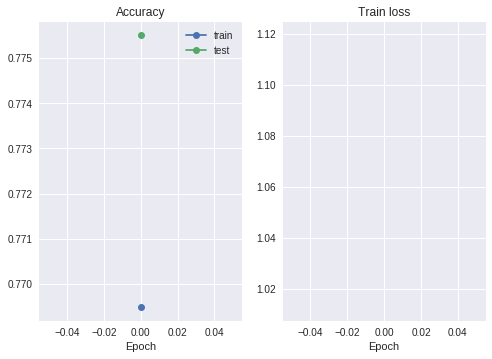

Epoch 2: Accuracy train=0.823, test=0.831; Loss=0.765


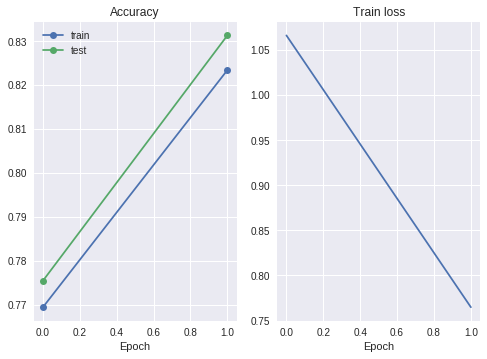

Epoch 3: Accuracy train=0.845, test=0.854; Loss=0.638


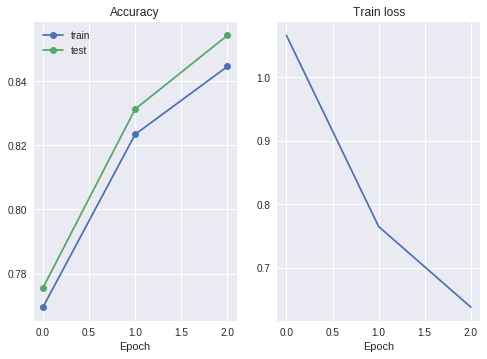

Epoch 4: Accuracy train=0.857, test=0.865; Loss=0.567


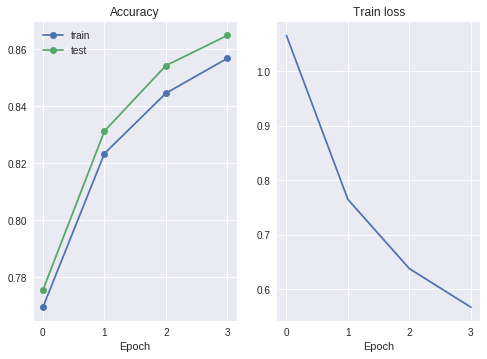

Epoch 5: Accuracy train=0.865, test=0.873; Loss=0.521


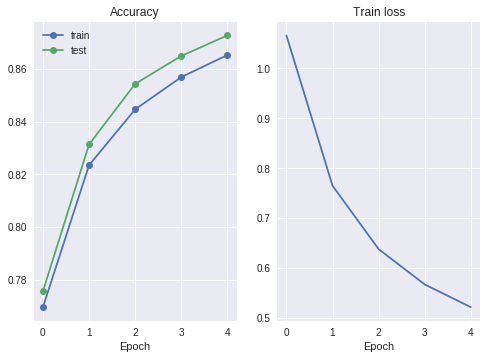

KeyboardInterrupt: ignored

In [0]:
class MLP(nn.Module):

    def __init__(self, *fc_sizes: int):
        """
        :param fc_sizes: fully-connected layer sizes
        """
        super().__init__()
        classifier = []
        for in_features, out_features in zip(fc_sizes[:-1], fc_sizes[1:]):
            linear = nn.Linear(in_features=in_features, out_features=out_features)
            classifier.append(linear)
        self.classifier = nn.Sequential(*classifier)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x


def full_forward_pass(model: nn.Module, loader: torch.utils.data.DataLoader):
    use_cuda = torch.cuda.is_available()
    outputs_full = []
    labels_full = []
    with torch.no_grad():
        for inputs, labels in iter(loader):
            if use_cuda:
                inputs = inputs.cuda()
            outputs = model(inputs)
            outputs_full.append(outputs.cpu())
            labels_full.append(labels)
    outputs_full = torch.cat(outputs_full, dim=0)
    labels_full = torch.cat(labels_full, dim=0)
    return outputs_full, labels_full


def calc_accuracy(labels_true, labels_predicted) -> float:
    accuracy = (labels_true == labels_predicted).type(torch.float32).mean()
    return accuracy.item()


class Trainer:

    def __init__(self, model: nn.Module, dataset_str: str):
        if torch.cuda.is_available():
            model = model.cuda()
        self.model = model
        self.train_loader = get_data_loader(dataset_str, train=True)
        self.eval_loader = get_data_loader(dataset_str, train=True, shuffle=False)
        self.test_loader = get_data_loader(dataset_str, train=False)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        print(f"Total batches: {len(self.train_loader)}")

    def forward_pass_train(self):
        outputs_train, labels_train = full_forward_pass(self.model, self.eval_loader)
        return outputs_train, labels_train

    def batch_finished(self, epoch, batch_id):
        pass

    def train(self, n_epochs=10):
        accuracy_train = []
        accuracy_test = []
        loss_train = []
        use_cuda = torch.cuda.is_available()
        print(f"Training {self.model}")
        for epoch in range(1, n_epochs+1):
            for batch_id, (images, labels) in enumerate(iter(self.train_loader)):
                if use_cuda:
                    images = images.cuda()
                    labels = labels.cuda()
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step(closure=None)
                self.batch_finished(epoch, batch_id)
            outputs_train, labels_train = self.forward_pass_train()
            outputs_test, labels_test = full_forward_pass(self.model, self.test_loader)
            loss_train.append(self.criterion(outputs_train, labels_train).item())
            accuracy_train.append(calc_accuracy(labels_train, labels_predicted=outputs_train.argmax(dim=1)))
            accuracy_test.append(calc_accuracy(labels_test, labels_predicted=outputs_test.argmax(dim=1)))
            print(f"Epoch {epoch}: Accuracy train={accuracy_train[-1]:.3f}, test={accuracy_test[-1]:.3f}; "
                  f"Loss={loss_train[-1]:.3f}")

            plt.subplot(121)
            plt.plot(range(epoch), accuracy_train, label='train', marker='o')
            plt.plot(range(epoch), accuracy_test, label='test', marker='o')
            plt.legend()
            plt.title("Accuracy")
            plt.xlabel("Epoch")
            plt.subplot(122)
            plt.plot(range(epoch), loss_train)
            plt.title("Train loss")
            plt.xlabel("Epoch")
#             plt.show()
        plt.show()


trainer = Trainer(model=MLP(784, 128, 10), dataset_str="MNIST")
trainer.train(n_epochs=5)

Now you want to analyze what happens with the information as it flows from layer to layer. To do so, we must bin the activations with a precision defined by us.

## Binning

The size of activation vector in a neural network changes from layer to layer. How do you compute the mutual information $I(X_{[784]}; T_{[128]})$ in a batch of B samples between the input $X$ and the hidden layer $T$ in a fully connected MLP 784 -> 128 -> 10?

The classical way to compute mutual information is to place semantically similar data in one bin. Data realizations can can be either scalars (e.g., predicted class labels) or vectors (layer activations). To maximize the estimate of the binned realization to the true unknown mutual information between $X_{[784]}$ and $T_{[128]}$, maximum entropy binning is used: each bin has the same number of data realizations. In this case, we maximize discrete entropy of $T$ to $H(T)=log_2 N_{bins}$. Then we compute conditional entropy $H(T|X)$ and calculate discrete mutual information from the binned data just like we did in lessons `02.MutualInformation.ipynb` and `03.HabituationSpikes.ipynb`:

$$I(X; T) = H(T) - H(T|X)$$

How do you bin $B$ samples of vector of size $N$ in $C$ clusters with the maximum entropy principle in mind?

In [0]:
def bin_vectors(vectors: np.ndarray, n_bins: int):
    """
    :param vectors: matrix of shape (#samples, #neurons)
    :param n_bins: number of bins to use
    :return: list of bin indices (between 0 and n_bins-1) of length #samples
    """
    # your code goes here
#     return np.random.randint(low=0, high=n_bins, size=len(vectors))
    cluster = sklearn.cluster.MiniBatchKMeans(n_clusters=n_bins)
    labels = cluster.fit_predict(vectors)
    return labels


Total batches: 235
Processing input data. Stage 1 ...
Processing input data. Stage 2 ...
Training MLP
Force update mutual information. Batch 0 / 235


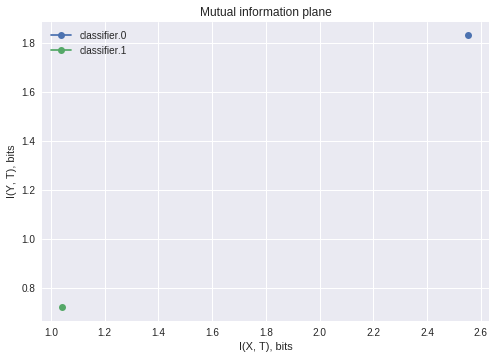

Force update mutual information. Batch 20 / 235


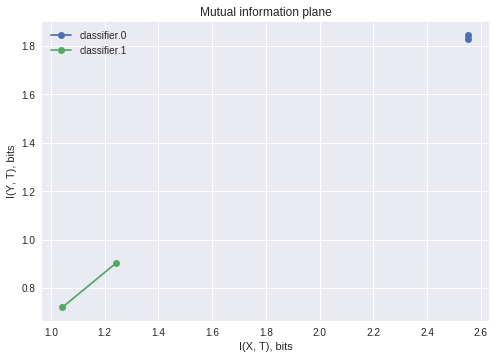

Force update mutual information. Batch 40 / 235


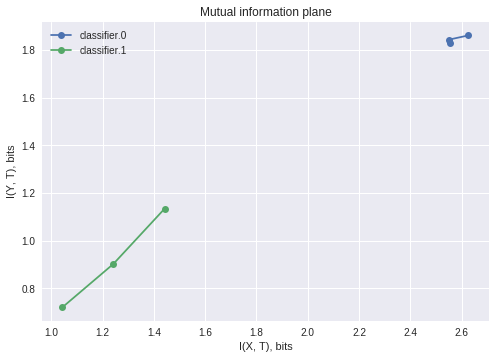

Force update mutual information. Batch 60 / 235


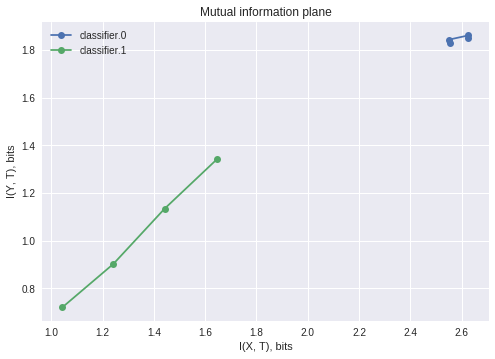

Force update mutual information. Batch 80 / 235


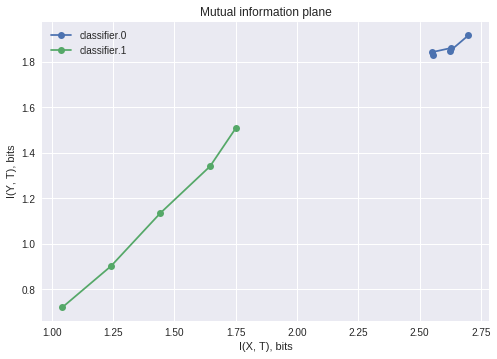

Force update mutual information. Batch 100 / 235


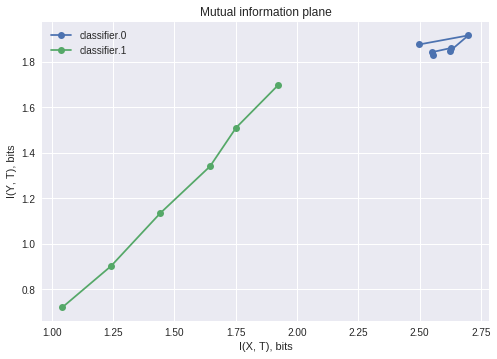

Force update mutual information. Batch 120 / 235


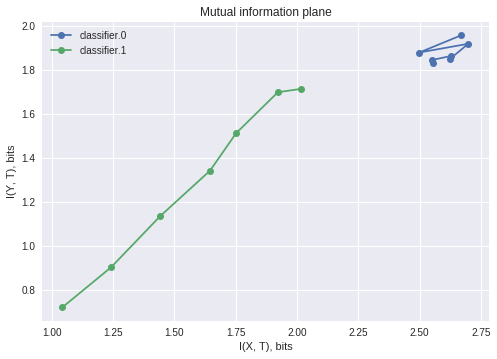

Force update mutual information. Batch 140 / 235


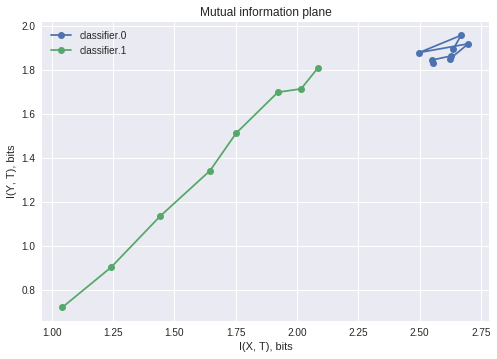

Force update mutual information. Batch 160 / 235


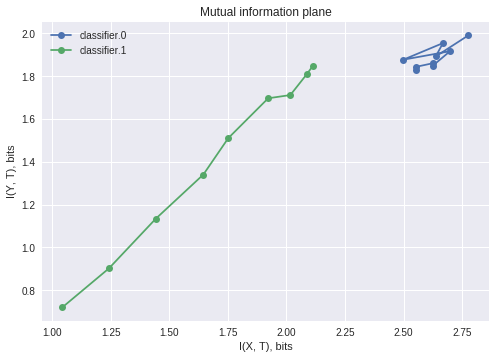

Force update mutual information. Batch 180 / 235


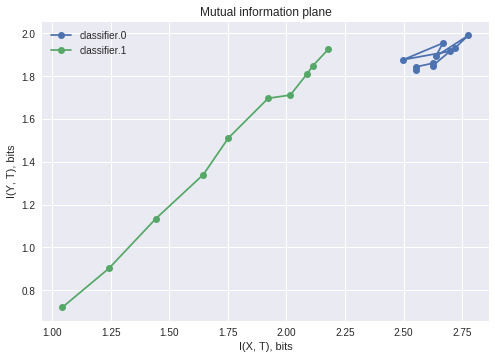

Force update mutual information. Batch 200 / 235


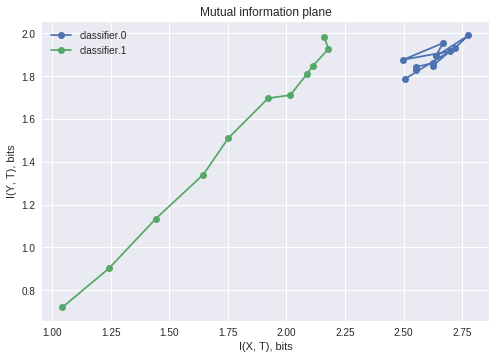

Force update mutual information. Batch 220 / 235


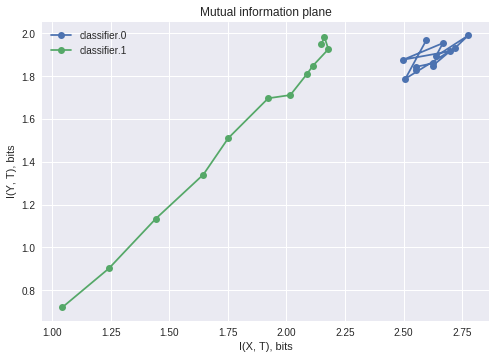

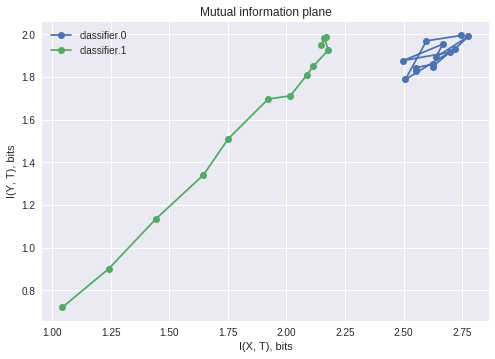

Epoch 1: Accuracy train=0.763, test=0.773; Loss=1.106


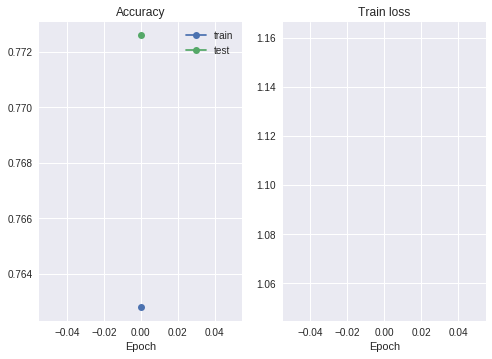

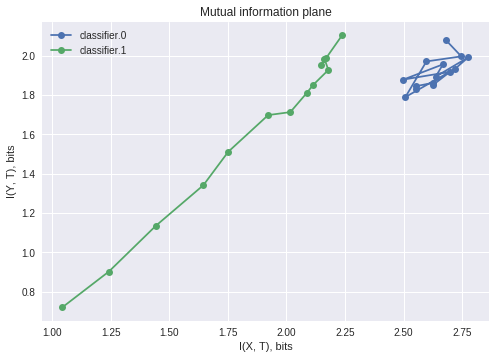

Epoch 2: Accuracy train=0.820, test=0.825; Loss=0.787


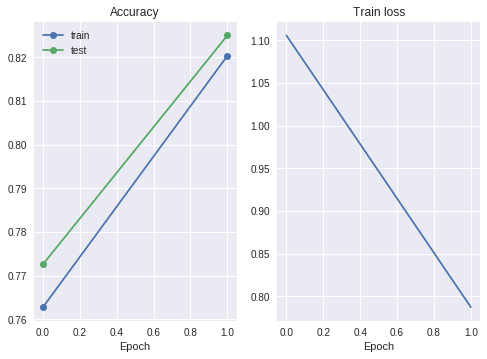

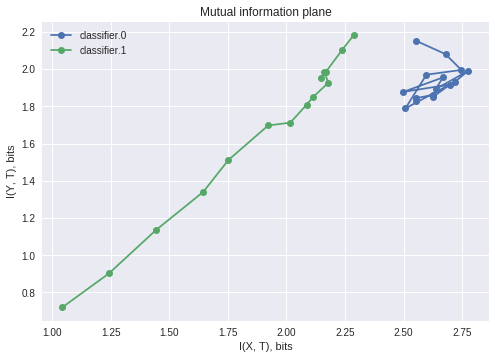

Epoch 3: Accuracy train=0.843, test=0.849; Loss=0.652


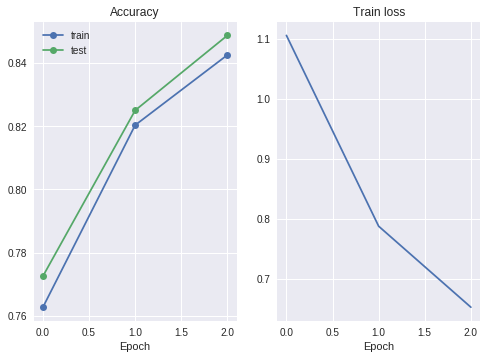

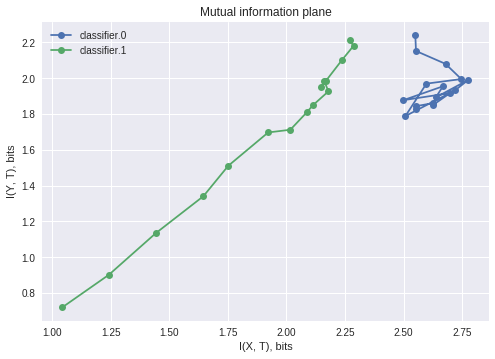

Epoch 4: Accuracy train=0.855, test=0.862; Loss=0.577


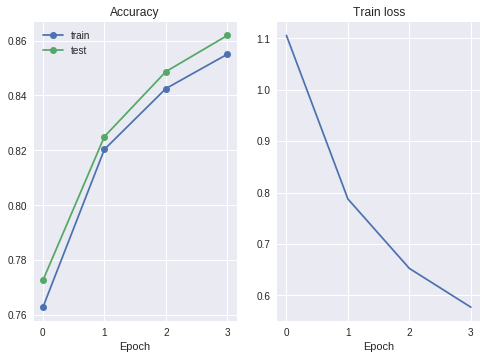

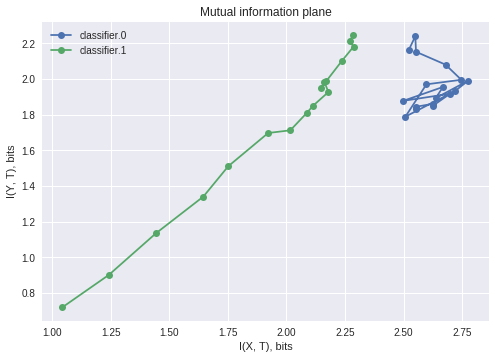

Epoch 5: Accuracy train=0.864, test=0.870; Loss=0.528


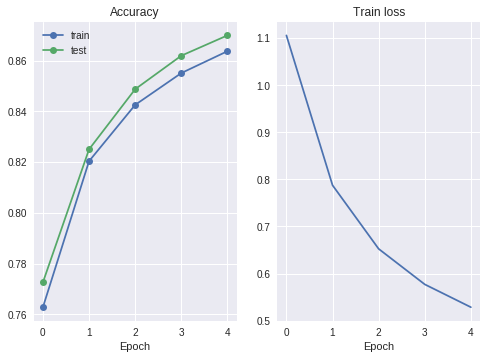

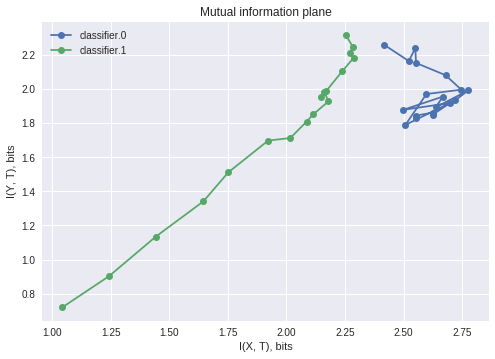

Epoch 6: Accuracy train=0.871, test=0.878; Loss=0.494


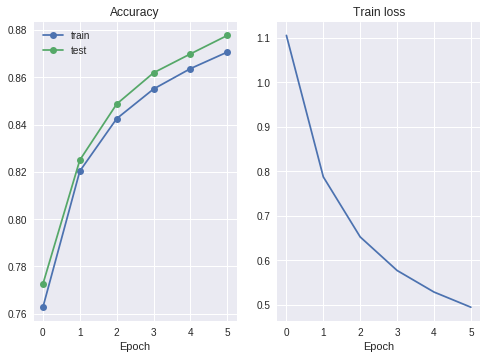

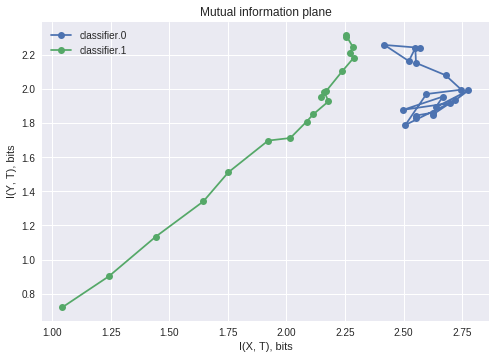

Epoch 7: Accuracy train=0.875, test=0.881; Loss=0.469


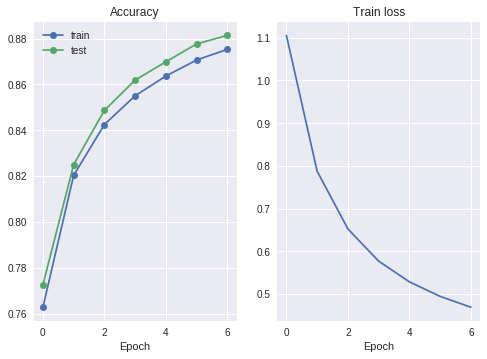

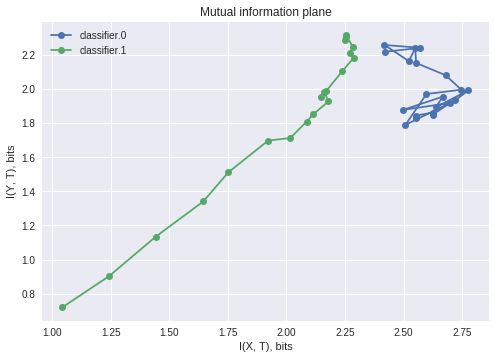

Epoch 8: Accuracy train=0.879, test=0.885; Loss=0.449


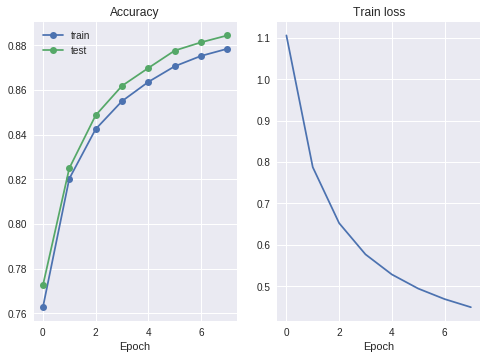

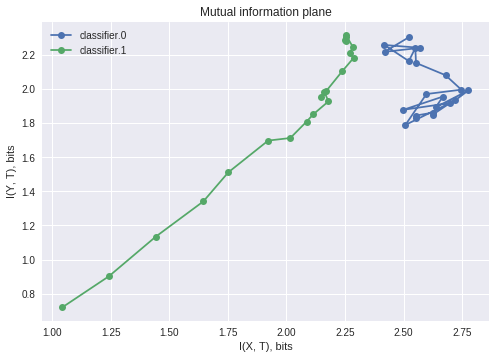

Epoch 9: Accuracy train=0.881, test=0.888; Loss=0.434


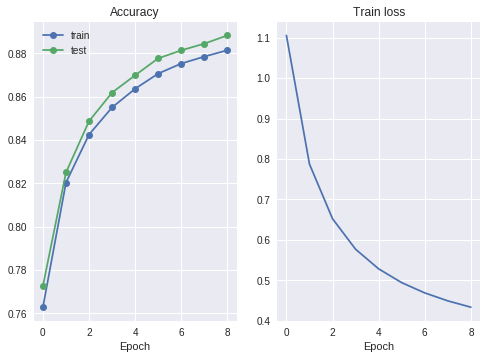

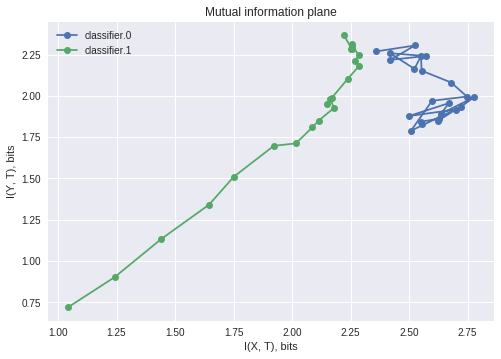

Epoch 10: Accuracy train=0.884, test=0.892; Loss=0.421


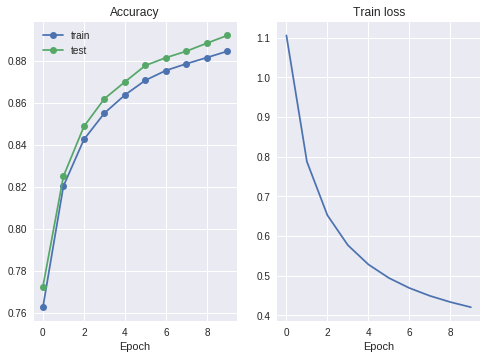

In [0]:
def discrete_entropy(digits) -> float:
    """
    :param digits: realizations of a discrete random variable X
    :return estimated entropy of X in bits
    """
    unique, counts = np.unique(digits, return_counts=True)
    proba = counts / len(digits)
    entropy = sum(proba * np.log2(1 / proba))
    return entropy


def discrete_mutual_information(x, y) -> float:
    """
    :param x: realizations of a discrete random variable X
    :param y: realizations of a discrete random variable Y
    :return: estimated mutual information between X and Y in bits
    """
    entropy_x = discrete_entropy(x)
    entropy_x_given_y = 0
    for y_unique in np.unique(y):
        mask = y == y_unique
        x_given_y = x[mask]
        entropy_x_given_y += discrete_entropy(x_given_y) * np.mean(mask)
    info = entropy_x - entropy_x_given_y
    return info


def find_named_layers(model: nn.Module, layer_class, name_prefix=''):
    for name, layer in model.named_children():
        yield from find_named_layers(layer, layer_class, name_prefix=f"{name_prefix}.{name}")
    if isinstance(model, layer_class):
        yield name_prefix.lstrip('.'), model


class MutualInformation:

    InfoXY = namedtuple("InfoXY", ('info_x', 'info_y'))

    def __init__(self, model: nn.Module, eval_loader, n_bins: int = 20):
        self.eval_loader = eval_loader
        self.n_bins = n_bins
        self.quantized = {}
        self.information = defaultdict(lambda: self.InfoXY(info_x=[], info_y=[]))
        self.is_active = False
        self.activations = defaultdict(list)
        self.layer_to_name = {}

        self.prepare_input()
        for name, layer in find_named_layers(model, layer_class=(nn.Linear, nn.Conv2d)):
            layer.register_forward_hook(self.save_activations)
            self.layer_to_name[layer] = name

    def force_update(self, model: nn.Module):
        self.start_listening()
        use_cuda = torch.cuda.is_available()
        with torch.no_grad():
            for images, labels in iter(self.eval_loader):
                if use_cuda:
                    images = images.cuda()
                model(images)  # outputs of each layer are saved implicitly
        self.finish_listening()

    def start_listening(self):
        self.activations.clear()
        self.is_active = True

    def finish_listening(self):
        self.is_active = False
        for hname in list(self.activations.keys()):
            activations = self.activations.pop(hname)
            activations = torch.cat(activations, dim=0)
            self.quantized[hname] = bin_vectors(vectors=activations.numpy(), n_bins=self.n_bins)
            info_x = discrete_mutual_information(self.quantized['input'], self.quantized[hname])
            info_y = discrete_mutual_information(self.quantized['target'], self.quantized[hname])
            self.information[hname].info_x.append(info_x)
            self.information[hname].info_y.append(info_y)

    def save_activations(self, module: nn.Module, tensor_input, tensor_output):
        if not self.is_active:
            return
        layer_name = self.layer_to_name[module]
        tensor_output_clone = tensor_output.cpu()
        if tensor_output_clone is tensor_output:
            tensor_output_clone = tensor_output_clone.clone()
        tensor_output_clone = tensor_output_clone.flatten(start_dim=1)
        self.activations[layer_name].append(tensor_output_clone)

    def prepare_input(self):
        targets = []
        classifier = sklearn.cluster.MiniBatchKMeans(n_clusters=self.n_bins,
                                                     batch_size=BATCH_SIZE,
                                                     compute_labels=False)
        print("Processing input data. Stage 1 ...")
        for images, labels in iter(self.eval_loader):
            images = images.flatten(start_dim=1)
            classifier.partial_fit(images, labels)
            targets.append(labels)
        targets = torch.cat(targets, dim=0)
        self.quantized['target'] = targets.numpy()

        print("Processing input data. Stage 2 ...")
        centroids_predicted = []
        for images, _ in iter(self.eval_loader):
            images = images.flatten(start_dim=1)
            centroids_predicted.append(classifier.predict(images))
        self.quantized['input'] = np.hstack(centroids_predicted)

    def plot(self):
        plt.clf()
        for layer_name, (info_x, info_y) in self.information.items():
            plt.plot(info_x, info_y, label=layer_name, marker='o')
        plt.title('Mutual information plane')
        plt.xlabel('I(X; T), bits')
        plt.ylabel('I(Y; T), bits')
        plt.legend()
        plt.show()


class TrainerInformation(Trainer):

    def __init__(self, model: nn.Module, dataset_str: str):
        super().__init__(model=model, dataset_str=dataset_str)
        self.mutual_info = MutualInformation(model=model, eval_loader=self.eval_loader)

    def forward_pass_train(self):
        self.mutual_info.start_listening()
        outputs_train, labels_train = super().forward_pass_train()
        self.mutual_info.finish_listening()
        self.mutual_info.plot()
        return outputs_train, labels_train

    def batch_finished(self, epoch, batch_id):
        if epoch == 1 and batch_id % 20 == 0:
            print(f"Force update mutual information. Batch {batch_id} / {len(self.train_loader)}")
            self.mutual_info.force_update(self.model)
            self.mutual_info.plot()


trainer = TrainerInformation(model=MLP(784, 128, 10), dataset_str='MNIST')
trainer.train(n_epochs=20)

#### Phase transition

When you train a network for 50-100 epochs and look at the information plane, you can see $I(X; T)$ changes its direction while $I(Y; T)$ still continue growing. If you examine Signal to Noise Ratio of parameters gradients (explained in Tishby paper), you may notice that gradients mean and standard deviation become equal at the same moment as $I(X; T)$ changes its direction in the information plane. Tishby claims the model undergoes a *phase transition* at this point. His opponents object his finding - an interesting discussion between the groups of authors and their experimental results you can find at https://openreview.net/forum?id=ry_WPG-A-.

#### Low I(X; T)

It's hard to cluster the input data in, say, 20 bins such that each bin contains equal amount of data (maximum entropy binning). That's why the information between $X$ and hidden layer activations $T$ in the example above is less than 3 bits. Imperfect binning algorithm of high-dimensional images lowers our estimate of $H(X)$ which in turn underestimates $I(X; T)$ *but on the same amount each time*. For the same reason, it's hard to calculate entropy of convolutional layers, unless more sophisticated estimator is used. Still, we can compare different network architectures on one plot, if we use same number of bins in our experiments.

## How I(Y; T) relates to accuracy

You might have noticed that the mutual information values of $I(Y; T)$ follow the model accuracy: the higher the accuracy, the more information gain; accuracy drops - and $I(Y; T)$ drops as well. Is there a direct way to estimate model accuracy from the mutual information and vice versa?

Firstly, we assume the training data is well balanced, i.e. all classes have nearly the same amount of samples such that the marginal distribution of the train data $p(y)={1 \over C}$, where $C$ is the number of classes. Then, assuming we shuffle the data which consists of $N \gg C$ points, entropy of $H(Y) \approx log_2 C$. 

Let $T$, hidden layer activations from all data, consists of a set of unique vectors $\{t_i\}_{i=1..|T|}$, $|T| \le N$. Then $H(Y|T)=\sum_t^{|T|} p_T(t)H(Y|T=t)$ and $H(Y|T=t) = \sum_{y=1}^{y=C}p_{model}(y|t)log_2 {1 \over p_{model}(y|t)}$ is the likelihood entropy. At the very beginning of training, $p_{model}(y|t)={1 \over C}$ is a poor estimator of a true unknown class $y$ and we're not interested much in the model accuracy as well as the mutual information. An interesting part becomes when the model has been trained to a some degree $\hat p$ such that, on average, it correctly predicts $\hat p$ times. And we assume that the model prediction distribution $p_{model}(y|t)$ is peaked at the true label class $(p_{model}(y=y_{true}|t)=\hat p)$ and equally distributed among other choices $(p_{model}(y \ne y_{true}|t)=p_{error} < \hat p)$. 

The final assumption is $|T| = C$ which, combined with the previous assumption, means that $T$'s layer activations are equally distributed among $C$ clusters. This is a mild assumption for entropy calculation, based on binning, especially when the network is trained and samples with one label tend to attract to special points in a $T$-space. We say there are at least $C$ such attractors in a $T$-space. It means that $\hat p + p_{error}(C - 1) = 1$. See the illustration below.

With our assumptions in mind, we have 

\begin{array}{lcl} p_{error} & = & {{1 - \hat p} \over {C - 1}} \\ H(Y|T=t) & = & \hat p log_2{1 \over \hat p} + \sum_{y=1}^{y=C-1} p_{error}log_2{1 \over p_{error}} & = & \hat p log_2{1 \over \hat p} + (1 - \hat p)log_2{{C-1} \over {1 - \hat p}} \\ p_T(t) & = & {1 \over C} \\ I(Y; T)& = &H(Y)-H(Y|T)& = &log_2 C - \hat p log_2{1 \over \hat p} - (1 - \hat p)log_2{{C-1} \over {1 - \hat p}} \end{array}

where $\hat p$ is the estimated accuracy.


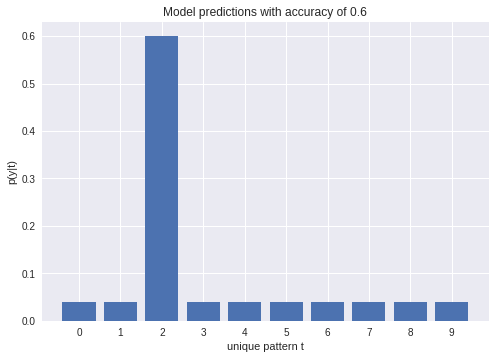

In [0]:
def visualize_balanced_predictor():
    p_hat = 0.6  # model accuracy
    C = 10
    p_predicted = np.full(shape=C, fill_value=(1 - p_hat) / C)
    p_predicted[2] = p_hat  # let assume it was class '2'
    plt.bar(range(C), p_predicted)
    plt.xlabel('unique pattern t')
    plt.xticks(range(C))
    plt.ylabel('p(y|t)')
    plt.title(f'Model predictions with accuracy of {p_hat}')
    plt.show()


visualize_balanced_predictor()

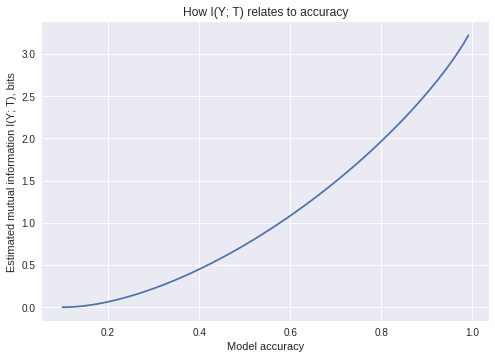

In [0]:
class AccuracyFromMutualInfo:
    def __init__(self, n_classes: int, resolution_bins=100):
        self.accuracy_binned = np.linspace(start=1 / n_classes, stop=1, num=resolution_bins, endpoint=False)
        entropy_correct = self.accuracy_binned * np.log2(1 / self.accuracy_binned)
        entropy_incorrect = (1 - self.accuracy_binned) * np.log2((n_classes - 1) / (1 - self.accuracy_binned))
        entropy_class_given_activations = entropy_correct + entropy_incorrect
        entropy_classes = np.log2(n_classes)
        self.mutual_info_binned = entropy_classes - entropy_class_given_activations

    def estimate_accuracy(self, mutual_info_bits: float) -> float:
        """
        :param mutual_info_bits: mutual information between the hidden layer T and the true class Y
        :return: estimated layer accuracy
        """
        bin_id = np.digitize(mutual_info_bits, bins=self.mutual_info_binned)
        bin_id = min(bin_id, len(self.accuracy_binned) - 1)
        accuracy_estimated = self.accuracy_binned[bin_id]
        return accuracy_estimated

    def plot(self):
        plt.plot(self.accuracy_binned, self.mutual_info_binned)
        plt.xlabel('Model accuracy')
        plt.ylabel('Estimated mutual information I(Y; T), bits')
        plt.title('How I(Y; T) relates to accuracy')
        plt.show()
        
        
AccuracyFromMutualInfo(n_classes=10).plot()

Here is the plot of real accuracy, compared with the estimated accuracy from the mutual information between the true label and the penultimate hidden layer (not the last one, as it's commonly used in machine learning) from the following model on MNIST:

```
EmbedderSDR(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=128, bias=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
```

![](https://i.imgur.com/4GI63YZ.png)

Even though the accuracy is estimated from the deep layer `fc1`, it still tracks the real accuracy quite well, and `fc2` mutual information gives even tighter bound (not shown here; more examples you can find by following the link shown in the "Conclusions" section). As expected, at the very beginning, the model is a poor predictor of the true class $Y$ and it violates our assumptions about the peakedness of the likelihood distribution $p_{model}(y|t)$ and the fact that we expect hidden layer activations to be clustered.

## Conclusions

Tishby called his information plane "x-rays" of a neural network. Here are some benefits they bring. The recipes shown below are not proved neither experimentally nor theoretically. They just follow a common sense.

* Compare not only the accuracy plots of train and validation data, but the train and validation infromation planes as well. They should look similar - an additional check.
* Between two curves of mutual information planes with the same $I(Y; T)$ choose the one that ends with the smallest $I(X; T)$ because it will be able to generalize better.
* When the training accuracy stucks at some optimum value, look at the gradients mean $M$ and standard deviation $S$: if gradient signal-to-noise ratio $SNR=M/S$ monotonically decreases with time, then, probably, nothing interesting is going to happen in the near future. But if the accuracy does not change much yet signal-to-noise ratio starts growing, maybe network's parameters have found an unseen escape from a local minima or rather they begin exploring the plateau in loss space much faster (and maybe not).
* The first phase, _fitting_ is crucial to occur. In this phase both $I(X; T)$ and $I(Y; T)$ grow till a phase transition occurs. If your model don't exhibit this behaviour, then it probably starts compressing the data right away and in most cases that I've observed it led to throwing away useful and not useful entropy of $X$, which in turn decreased $I(Y; T)$ as well (image that your data is pixel-wise randomly masked).

More examples of mutual information planes with different network architectures and on other datasets you can find at http://ec2-34-227-113-244.compute-1.amazonaws.com:8099.